In [50]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import seaborn as sns
sns.set()

In [2]:
# set the random seed
seed = 800815
np.random.seed(seed)
N = 3
dev = qml.device("default.qubit", wires=N)

In [3]:
# Generate random state
def random_state(num_qubits, seed):
  rs = unitary_group.rvs(dim=2**num_qubits, random_state=rnd.default_rng(seed))
  return rs[0]

def random_observable(num_qubits, seed):
  real, img = rnd.random((2, 2**num_qubits, 2**num_qubits))
  
  real = real+real.T
  img = img - img.T
  
  H = real + 1j*img
  return H

H = random_observable(N, seed)

In [4]:
np.real(np.linalg.eig(H)[0])

tensor([ 8.80289681, -2.3581051 , -1.83165003, -0.9786409 ,  2.17549758,
         1.63960714,  1.20572138,  0.16142326], requires_grad=True)

In [5]:
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    
    qml.RY(params[3], wires=0)
    qml.RX(params[4], wires=1)
    qml.RZ(params[5], wires=2)
    
    qml.broadcast(qml.CNOT, wires=[0,1,2], pattern="ring")
    
    return qml.expval(qml.Hermitian(H, wires=dev.wires))

In [6]:
params = np.random.random([6], requires_grad=True)

print("Params are: ", params)
print("Expectation value:", circuit(params))

Params are:  [0.93111819 0.43439045 0.1545537  0.99987185 0.47772167 0.98707036]
Expectation value: 2.575751674696278


In [7]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])
i = np.eye(2)
np.linalg.eig(np.kron(y, z))

(array([ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j]),
 tensor([[-0.        -0.70710678j,  0.70710678+0.j        ,
          -0.        -0.j        , -0.        +0.j        ],
         [-0.        +0.j        ,  0.        +0.j        ,
          -0.        +0.70710678j,  0.70710678+0.j        ],
         [ 0.70710678+0.j        ,  0.        -0.70710678j,
          -0.        -0.j        , -0.        +0.j        ],
         [-0.        +0.j        ,  0.        +0.j        ,
           0.70710678+0.j        , -0.        +0.70710678j]], requires_grad=True))

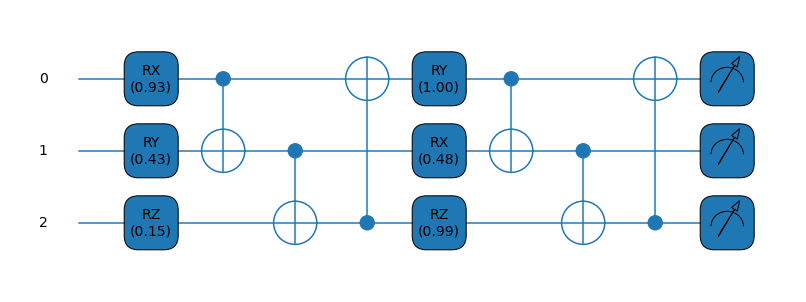

In [8]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.savefig("images/circuit_1.png")
plt.show()

In [9]:
def parameter_shift_term(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/2
  forward_exp = circuit(new_params)
  
  new_params[idx] -= np.pi
  backward_exp = circuit(new_params)
  
  grad = 0.5*(forward_exp - backward_exp)
  return grad

In [10]:
print(parameter_shift_term(circuit, params, 0))

1.4428470211171902


In [11]:
def parameter_shift_all(circuit, params):
  grads = np.zeros([len(params)])
  for idx, param in enumerate(params):
    grads[idx] = parameter_shift_term(circuit, params, idx)
  return grads

In [12]:
print(parameter_shift_all(circuit, params))

[ 1.44284702 -0.19947688  0.          1.08394825 -0.18399324  1.08050937]


In [13]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

1.4428470211171898


In [14]:
def update_params(params, grads, lr=0.01):
  return params - lr*grads

Iter 0 - Expval of circuit: 0.7017980054618883
Iter 100 - Expval of circuit: -2.030687169363362
Iter 200 - Expval of circuit: -2.0833208427173036
Iter 300 - Expval of circuit: -2.0892205881258334
Iter 400 - Expval of circuit: -2.091105479576198
Iter 500 - Expval of circuit: -2.091873959612317
Iter 600 - Expval of circuit: -2.09219827872018
Iter 700 - Expval of circuit: -2.0923361442315955
Iter 800 - Expval of circuit: -2.092395019264227
Iter 900 - Expval of circuit: -2.092420292696787


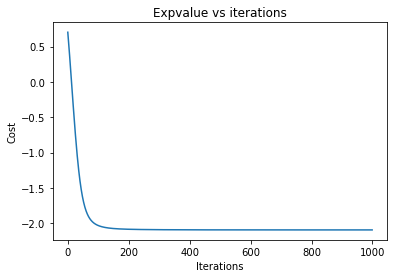

In [15]:
params = np.random.random([6], requires_grad=True)

def train(circuit, params, lr=0.01, numiters = 1000):
  costs = []
  lrs = []
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      lr*=0.99
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
    grads = parameter_shift_all(circuit, params)
    params = update_params(params, grads, lr)
    curr_cost = circuit(params)
    costs.append(prev_cost)
    lrs.append(lr)
  return params, costs, lrs
new_params, costs, lrs = train(circuit, params)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

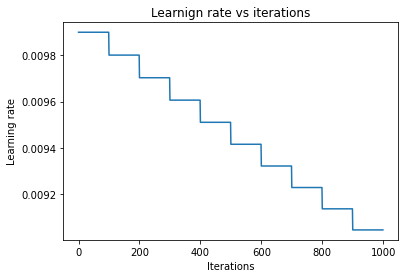

In [16]:
plt.plot(np.arange(1000), lrs)
plt.title("Learnign rate vs iterations")
plt.ylabel("Learning rate")
plt.xlabel("Iterations")
plt.show()

In [17]:
new_params

tensor([ 1.50696429, -0.57250401,  0.13329564,  0.05073803,  0.45317067,
        -0.90789832], requires_grad=True)

In [18]:
params

tensor([0.84636466, 0.59526116, 0.13329564, 0.15676431, 0.26890075,
        0.00733987], requires_grad=True)

## Research Question 1
### How good is learning when we use the 2 term param shift rule?

**Custom gate**
[How to create custom gates](https://pennylane.ai/blog/2021/05/how-to-add-custom-gates-and-templates-to-pennylane/)

In [19]:
gen = random_observable(2, seed)
eigs = np.real(np.linalg.eig(gen)[0])
max_eig = np.max(eigs)
min_eig = np.min(eigs)
print(eigs, max_eig, min_eig)

[ 4.4596346   0.72308071 -0.96655622 -1.8232704 ] 4.459634595281225 -1.8232703995290034


In [20]:
import pennylane as qml
from pennylane.operation import Operation
from pennylane import numpy as np

class Gmu(Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"

    grad_method = "A"
    grad_recipe = None # This is the default but we write it down explicitly here.

    generator = [gen]

#     @staticmethod
#     def decomposition(theta, wires):
#         return [qml.PauliRot(theta, 'XX', wires=wires)]

In [21]:
dev2 = qml.device('default.qubit', wires=2)

@qml.qnode(dev2)
def cirq(params):
    Gmu(params[0], wires=[0, 1])
    return qml.expval(qml.PauliX(0) @ qml.PauliY(1))

cirq([0.3])

DeviceError: Gate Gmu not supported on device default.qubit.autograd

In [22]:
params = np.random.random([1], requires_grad=True)
new_params, costs, lrs = train(cirq, params, lr=0.01, numiters=5000)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

DeviceError: Gate Gmu not supported on device default.qubit.autograd

In [23]:
np.linalg.eig(np.kron(z,x))

(array([ 1., -1.,  1., -1.]),
 tensor([[ 0.70710678, -0.70710678,  0.        ,  0.        ],
         [ 0.70710678,  0.70710678,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.70710678,  0.70710678],
         [ 0.        ,  0.        , -0.70710678,  0.70710678]], requires_grad=True))

### 3rd device
checking if paui rotation give good grads


In [24]:
dev3 = qml.device('default.qubit', wires=2)

@qml.qnode(dev3, diff_method="parameter-shift")
def cirq2(params):
    qml.PauliRot(params[0], "XX", wires=[0,1])
    return qml.expval(qml.PauliX(0) @ qml.PauliY(1))

cirq2([0.3])

tensor(-0.29552021, requires_grad=True)

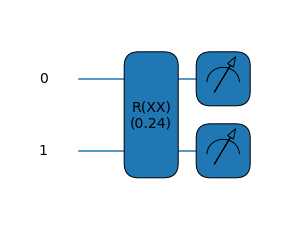

In [25]:
fig, ax = qml.draw_mpl(cirq2, decimals=2)(params)

Iter 0 - Expval of circuit: -0.07124409731420223
Iter 100 - Expval of circuit: -0.7870912303014317
Iter 200 - Expval of circuit: -0.9672792711741605
Iter 300 - Expval of circuit: -0.9952781283137213
Iter 400 - Expval of circuit: -0.9993135580716823
Iter 500 - Expval of circuit: -0.9998984313151305
Iter 600 - Expval of circuit: -0.9999846839908895
Iter 700 - Expval of circuit: -0.9999976461962065
Iter 800 - Expval of circuit: -0.9999996313925607
Iter 900 - Expval of circuit: -0.9999999411906065


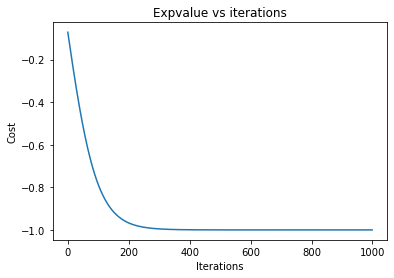

In [26]:
params = np.random.random([1], requires_grad=True)
def train(circuit, params, lr=0.01, numiters = 1000):
  costs = []
  lrs = []
  grad_function = qml.grad(circuit)
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      lr*=0.99
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
    grads = np.array(grad_function(params)[0])
    params = update_params(params, grads, lr)
    curr_cost = circuit(params)
    costs.append(prev_cost)
    lrs.append(lr)
  return params, costs, lrs
new_params, costs, lrs = train(cirq2, params)

plt.plot(np.arange(1000), costs)
plt.title("Expvalue vs iterations")
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

# Custom linear combination of pauli words

In [168]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])
i = np.eye(2)
mat1 = np.kron(np.kron(np.kron(x, y),i),i)
mat2 = np.kron(np.kron(np.kron(i, y),z),i)
mat3 = np.kron(np.kron(np.kron(i, i),z),x)
mat4 = mat1-mat2+mat3
eigs = np.linalg.eig(-0.5*mat4)
print(np.real(eigs[0]))

[-1.5  1.5  0.5 -1.5  1.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5]


[ 12.5 -12.5  12.5 -12.5]


In [193]:
wires=4
devcustom1 = qml.device("default.qubit", wires=wires)
H = random_observable(wires, seed)
print(np.real(np.linalg.eig(H)[0]))
@qml.qnode(devcustom1, diff_method="backprop")
def custom_circuit(params):
  qml.PauliRot(params[0], "XY", wires=[0,1])
  qml.PauliRot(-1*params[0], "YZ", wires=[1,2])
  qml.PauliRot(params[0], "ZX", wires=[2,3])
  qml.RX(params[1], wires=0)
  qml.RX(params[2], wires=1)
  qml.RX(params[3], wires=2)
  qml.RX(params[4], wires=3)
  qml.broadcast(qml.CNOT, wires=devcustom1.wires, pattern="ring")
  qml.PauliRot(params[5], "XY", wires=[0,1])
  qml.PauliRot(-1*params[5], "YZ", wires=[1,2])
  qml.PauliRot(params[5], "ZX", wires=[2,3])
  qml.broadcast(qml.CNOT, wires=devcustom1.wires, pattern="ring")
  return qml.expval(qml.Hermitian(H, wires=devcustom1.wires))

[ 1.69106789e+01 -4.60081959e+00  4.05942082e+00 -2.84563508e+00
 -2.54295446e+00  2.87254943e+00  2.51320120e+00 -2.00778188e+00
 -1.54829526e+00  1.80104459e+00  1.45026402e+00 -8.82710037e-01
 -4.06703454e-01 -1.09211742e-02  7.97861606e-01  5.70855491e-01]


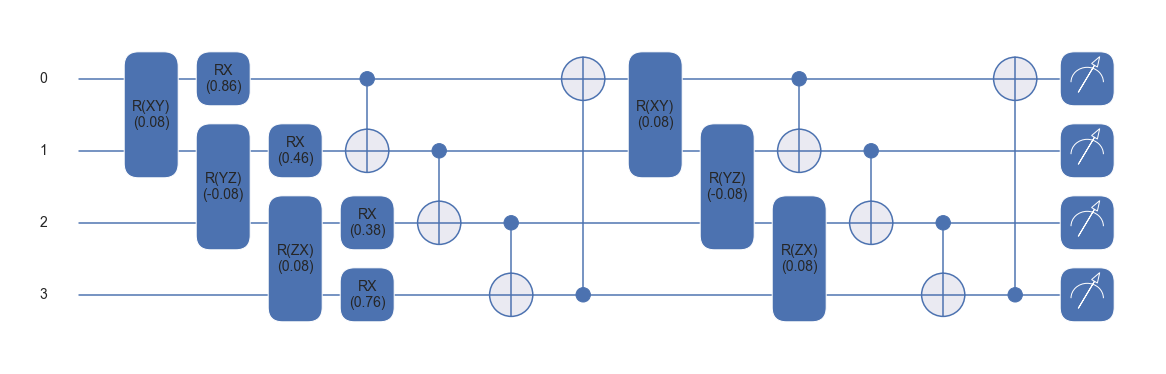

In [194]:
print()
params = np.random.random([6], requires_grad=True)
fig, ax = qml.draw_mpl(custom_circuit, decimals=2)(params)

In [231]:
def parameter_shift_term_custom(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/6
  forward_exp = circuit(new_params)
  
  new_params[idx] -= np.pi/3
  backward_exp = circuit(new_params)
  
  grad = (1.5)*(forward_exp - backward_exp)
  return grad

In [232]:
def parameter_shift_all_custom(circuit, params):
  grads = np.zeros([len(params)])
  for idx, param in enumerate(params):
    grads[idx] = parameter_shift_term_custom(circuit, params, idx)
  return grads

In [233]:
def update_params(params, grads, lr=0.01):
  return params - lr*grads

In [234]:
import tqdm

In [277]:
# params = np.random.random([6], requires_grad=True)
print(f"params {params}")
grad_function = qml.grad(custom_circuit)
print(f"real grad {grad_function(params)[0]}, real param {params}")
print(f"approx grad {parameter_shift_term_custom(custom_circuit, params, 0)}")
def trainPauliWordCirq(circuit, params, gradfuns, lr=0.1, numiters = 1000):
  costs = []
  lrs = []
  allapproxgrads = []
  allrealgrads = []
  grad_function = qml.grad(circuit)
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%100 == 0:
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
      
    # approx grad calculation
    approxgrads = np.array([g(circuit, params, i) for i, g in enumerate(gradfuns)])
    # real grad calculation
    realgrad = grad_function(params)
    # update params
    params = update_params(params, approxgrads, lr)
    curr_cost = circuit(params)
    
    
    
    ### collect data
    costs.append(prev_cost)
    lrs.append(lr)
    allapproxgrads.append(approxgrads)
    allrealgrads.append(realgrad)
    

  return params, costs, lrs, allapproxgrads, allrealgrads

params [0.0841557  0.86416542 0.4626533  0.37909641 0.7564178  0.07910414]
real grad 0.3859230828862592, real param [0.0841557  0.86416542 0.4626533  0.37909641 0.7564178  0.07910414]
approx grad 0.5306308859027549


In [278]:
parameter_shift_all_custom(custom_circuit, params)

tensor([ 0.53063089,  0.2412754 , -0.74792542,  0.52549841,  0.88188921,
        -0.58862737], requires_grad=True)

In [279]:
numiters = 1000
new_params, approxcosts, lrs, allapproxgrads, allrealgrads = trainPauliWordCirq(custom_circuit, params, [parameter_shift_term_custom, parameter_shift_term, parameter_shift_term, parameter_shift_term, parameter_shift_term, parameter_shift_term_custom],lr=0.01, numiters=numiters)



Iter 0 - Expval of circuit: 0.46667103985955216
Iter 100 - Expval of circuit: -1.4683858561037488
Iter 200 - Expval of circuit: -1.999543164188349
Iter 300 - Expval of circuit: -2.065596360822709
Iter 400 - Expval of circuit: -2.077575801540889
Iter 500 - Expval of circuit: -2.0814283919835943
Iter 600 - Expval of circuit: -2.0831061150093597
Iter 700 - Expval of circuit: -2.0839643449644463
Iter 800 - Expval of circuit: -2.084452854245771
Iter 900 - Expval of circuit: -2.0847534649812043


In [280]:
# len(app)
green = "#209494"
orange = "#ED7D31"
red = "xkcd:brick red"
blue = "xkcd:cerulean"
pink = "xkcd:bright pink"

In [281]:
allrealgrads = np.array(allrealgrads)
allapproxgrads = np.array(allapproxgrads)
print(allrealgrads.shape, allapproxgrads.shape)


(1000, 6) (1000, 6)


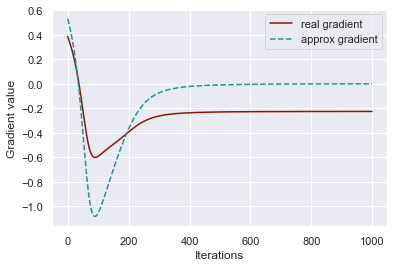

In [282]:
plt.plot(np.arange(numiters), allrealgrads[:, 0], label="real gradient", color="xkcd:brick red")
plt.plot(np.arange(numiters), allapproxgrads[:,0], label="approx gradient", color="#209494", linestyle="dashed")
plt.ylabel("Gradient value")
plt.xlabel("Iterations")
plt.legend()
plt.show()

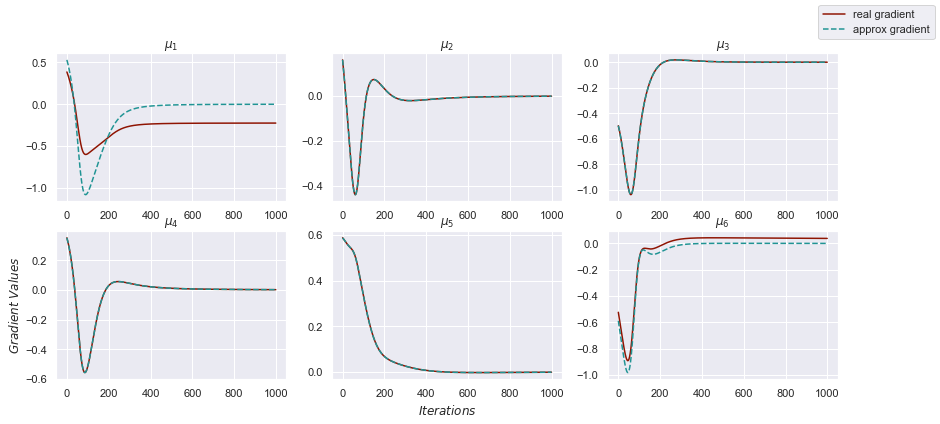

In [283]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6))
alltitles = ["$\mu_{1}$", "$\mu_{2}$", "$\mu_{3}$", "$\mu_{4}$", "$\mu_{5}$", "$\mu_{6}$"]
for i, (ax, N) in enumerate(zip(np.ndarray.flatten(axs), params)):
    # Plot cost function evaluations
    ax.plot(np.arange(numiters), allrealgrads[:, i], label="real gradient", color="xkcd:brick red")
    ax.plot(np.arange(numiters), allapproxgrads[:,i], label="approx gradient", color="#209494", linestyle="dashed")
    plt.legend
    # Axis and plot labels
    ax.set_title(f"{alltitles[i]}")

_ = axs[1][1].set_xlabel("$Iterations$")
_ = axs[1][0].set_ylabel("$Gradient$ $Values$")
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.savefig("images/fouriergrads.svg")
plt.show()

In [284]:
print(params, new_params)

[0.0841557  0.86416542 0.4626533  0.37909641 0.7564178  0.07910414] [1.41043822 1.10161439 1.45418182 0.6148435  0.03988388 0.88496891]


In [285]:
(allapproxgrads[:,5])/allrealgrads[:,5]

tensor([ 1.12385793e+00,  1.12270396e+00,  1.12160555e+00,
         1.12055939e+00,  1.11956234e+00,  1.11861148e+00,
         1.11770400e+00,  1.11683731e+00,  1.11600894e+00,
         1.11521660e+00,  1.11445814e+00,  1.11373155e+00,
         1.11303496e+00,  1.11236665e+00,  1.11172502e+00,
         1.11110859e+00,  1.11051603e+00,  1.10994612e+00,
         1.10939774e+00,  1.10886993e+00,  1.10836179e+00,
         1.10787257e+00,  1.10740160e+00,  1.10694831e+00,
         1.10651225e+00,  1.10609303e+00,  1.10569038e+00,
         1.10530408e+00,  1.10493400e+00,  1.10458008e+00,
         1.10424232e+00,  1.10392078e+00,  1.10361555e+00,
         1.10332677e+00,  1.10305458e+00,  1.10279918e+00,
         1.10256071e+00,  1.10233936e+00,  1.10213523e+00,
         1.10194842e+00,  1.10177896e+00,  1.10162680e+00,
         1.10149179e+00,  1.10137367e+00,  1.10127204e+00,
         1.10118636e+00,  1.10111592e+00,  1.10105979e+00,
         1.10101686e+00,  1.10098577e+00,  1.10096495e+0

In [286]:
np.var(np.real(eigs[0]))

tensor(0.75, requires_grad=True)

In [287]:
np.real(eigs[0])

tensor([-1.5,  1.5,  0.5, -1.5,  1.5,  0.5, -0.5, -0.5,  0.5, -0.5,  0.5,
        -0.5,  0.5, -0.5,  0.5, -0.5], requires_grad=True)

In [288]:
dot = np.dot(allrealgrads, allapproxgrads.T)
dot= np.diag(dot)
norm_realgrads = np.linalg.norm(allrealgrads, axis=1)
norm_approxgrads = np.linalg.norm(allapproxgrads, axis=1)
print(dot/(norm_realgrads*norm_approxgrads))

[0.99332901 0.99349156 0.99366241 0.9938413  0.99402794 0.99422192
 0.99442278 0.99463    0.99484294 0.99506092 0.99528314 0.99550876
 0.99573682 0.99596631 0.99619612 0.99642509 0.99665196 0.99687543
 0.99709413 0.99730663 0.99751145 0.99770709 0.99789197 0.99806452
 0.99822314 0.9983662  0.99849207 0.99859913 0.99868577 0.99875039
 0.99879143 0.99880736 0.9987967  0.99875804 0.99869003 0.99859141
 0.99846101 0.99829776 0.99810072 0.99786907 0.99760214 0.99729938
 0.99696042 0.99658505 0.99617321 0.99572503 0.9952408  0.99472096
 0.99416615 0.99357713 0.99295482 0.99230026 0.99161465 0.99089926
 0.99015547 0.98938475 0.98858862 0.98776869 0.98692658 0.98606399
 0.98518262 0.98428424 0.98337065 0.98244366 0.98150517 0.98055712
 0.97960152 0.97864045 0.97767608 0.9767107  0.97574668 0.97478652
 0.97383284 0.97288834 0.97195586 0.97103831 0.97013867 0.96925998
 0.96840528 0.9675776  0.96677992 0.96601513 0.96528596 0.96459501
 0.96394465 0.96333703 0.962774   0.96225718 0.96178786 0.9613

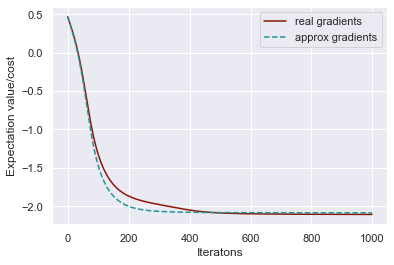

In [292]:
plt.plot(costs, color="xkcd:brick red", label="real gradients")
plt.plot(approxcosts, color=green, linestyle="dashed", label="approx gradients")
plt.xlabel("Iteratons")
plt.ylabel("Expectation value/cost")
plt.legend()
plt.savefig("images/toyCostComparison.svg")
plt.show()

## QAOA

In [293]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

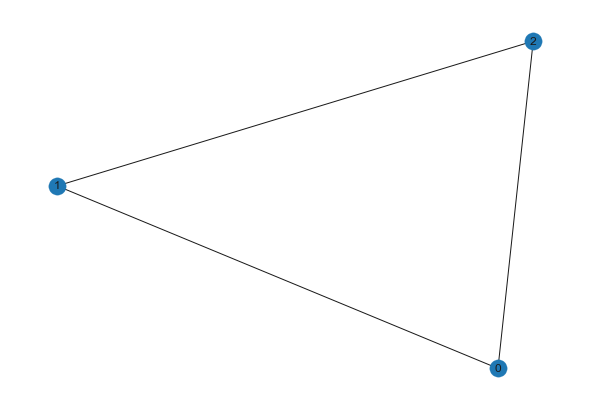

In [572]:
edges = [(0, 1), (1, 2), (2, 0)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [597]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]


In [600]:
def parameter_shift_term_cost_ham(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/10
  new_params = new_params.reshape((-1,2))
  forward_exp = circuit(new_params)
  new_params = np.ndarray.flatten(new_params)
  new_params[idx] -= np.pi/5
  new_params = new_params.reshape((-1,2))
  backward_exp = circuit(new_params)
  
  grad = (2.5)*(forward_exp - backward_exp)
  return grad

In [601]:
def parameter_shift_term_mixer_ham(circuit, params, idx):
  new_params = np.copy(params)
  new_params[idx] += np.pi/2
  new_params = new_params.reshape((-1,2))
  forward_exp = circuit(new_params)
  new_params = np.ndarray.flatten(new_params)
  new_params[idx] -= np.pi
  new_params = new_params.reshape((-1,2))
  
  backward_exp = circuit(new_params)
  
  grad = (0.5)*(forward_exp - backward_exp)
  return grad

In [602]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [603]:
def trainPauliWordCirqQAOA(circuit, params, gradfuns, lr=0.1, numiters = 1000):
  costs = []
  lrs = []
  allapproxgrads = []
  allrealgrads = []
  grad_function = qml.grad(circuit)
  for i in range(numiters):
    prev_cost = circuit(params)
    if i%10 == 0:
      print(f"Iter {i} - Expval of circuit: {circuit(params)}")
      
    # approx grad calculation
    params = np.ndarray.flatten(params)
    approxgrads = np.array([g(circuit, params, i) for i, g in enumerate(gradfuns)])
    # real grad calculation
    params = params.reshape((-1,2))
    realgrad = grad_function(params)
    # update params
    params = update_params(np.ndarray.flatten(params), approxgrads, lr)
    params = params.reshape((-1,2))
    
    
    
    ### collect data
    costs.append(prev_cost)
    lrs.append(lr)
    allapproxgrads.append(approxgrads)
    allrealgrads.append(realgrad)

  return params, costs, lrs, allapproxgrads, allrealgrads

In [604]:
wires = range(3)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [605]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [606]:
numiters = 100
params = np.array([[0.5, 0.5], [0.1, 0.3]], requires_grad=True)
print(params)
new_params, approxcosts, lrs, allapproxgrads, allrealgrads = trainPauliWordCirqQAOA(cost_function, params, [parameter_shift_term_cost_ham, parameter_shift_term_mixer_ham, parameter_shift_term_cost_ham, parameter_shift_term_mixer_ham],lr=0.05, numiters=numiters)



[[0.5 0.5]
 [0.1 0.3]]
Iter 0 - Expval of circuit: 0.5523014876561518
Iter 10 - Expval of circuit: -0.32337274775662644
Iter 20 - Expval of circuit: -0.4645560826779407
Iter 30 - Expval of circuit: -0.5551074056315244
Iter 40 - Expval of circuit: -0.6153824212624467
Iter 50 - Expval of circuit: -0.6583409947991914
Iter 60 - Expval of circuit: -0.6909357980147917
Iter 70 - Expval of circuit: -0.7166720070738338
Iter 80 - Expval of circuit: -0.7375559954768616
Iter 90 - Expval of circuit: -0.7548541478987543


In [607]:
new_params

tensor([[ 0.4725273 ,  0.12546753],
        [-0.56793622,  0.3       ]], requires_grad=True)

In [608]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.1, 0.3]], requires_grad=True)

In [615]:
for i in range(steps):
    print(cost_function(params))
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

-1.053885535037776
-1.058170963059159
-1.0623712311668134
-1.066488053889008
-1.0705223157451311
-1.0744742326515173
-1.0783435030928707
-1.08212944804186
-1.0858311385412778
-1.089447509926439
-1.0929774618462649
-1.0964199435177673
-1.0997740239929417
-1.1030389475981504
-1.1062141750921985
-1.109299411450403
-1.112294621493036
-1.1152000348181905
-1.1180161416603163
-1.120743681372168
-1.1233836252233487
-1.1259371551319177
-1.1284056398101838
-1.1307906096275135
-1.1330937312883
-1.1353167832076299
-1.1374616322543412
-1.1395302123318858
-1.141524505089683
-1.1434465229061646
-1.1452982941618228
-1.1470818507259612
-1.148799217512933
-1.150452403919207
-1.1520433969282808
-1.1535741556620565
-1.1550466071612564
-1.1564626431901996
-1.1578241178796937
-1.1591328460434638
-1.1603906020264791
-1.1615991189661308
-1.1627600883685558
-1.1638751599217452
-1.1649459414840488
-1.1659739992012097
-1.1669608577170907
-1.1679080004530684
-1.1688168699387411
-1.1696888681824773
-1.170525357074

In [616]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)




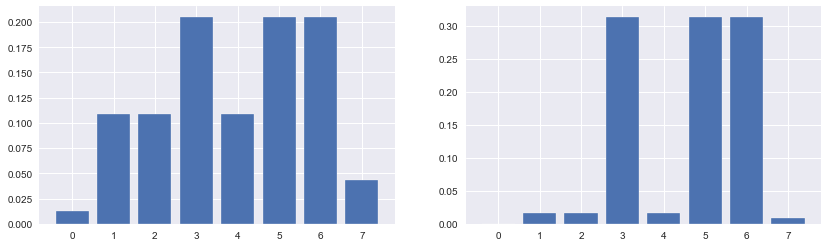

In [625]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
plt.style.use("seaborn")
probs = probability_circuit(new_params[0], new_params[1])
axs[0].bar(range(2 ** len(wires)), probs)
probs = probability_circuit(params[0], params[1])
axs[1].bar(range(2 ** len(wires)), probs)
plt.savefig("images/raqaoahist.svg")
plt.show()


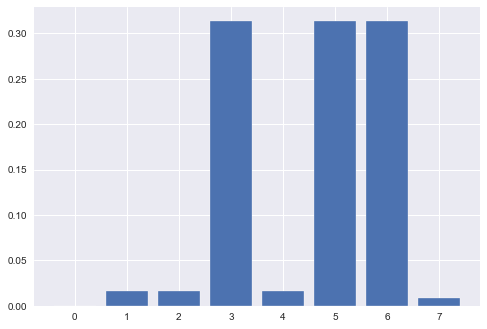

In [623]:
probs = probability_circuit(params[0], params[1])
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig("images/realqaoahist.svg")
plt.show()

(<Figure size 576x288 with 1 Axes>, <Axes:>)

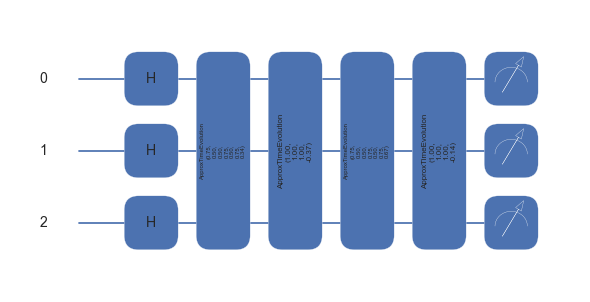

In [613]:
qml.draw_mpl(cost_function, decimals=2)(params)

In [588]:
bin(6)

'0b110'

In [589]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])
i = np.eye(2)
mat1 = np.kron(np.kron(np.kron(i, i),z),i)
mat2 = np.kron(np.kron(np.kron(z, i),i),i)
mat3 = np.kron(np.kron(np.kron(i, z),i),i)
mat4 = np.kron(np.kron(np.kron(i, i),z),i)
mat5 = np.kron(np.kron(np.kron(z, z),i),i)
mat6 = np.kron(np.kron(np.kron(z, i),z),i)
mat7 = np.kron(np.kron(np.kron(i, z),z),i)
mat8 = np.kron(np.kron(np.kron(i, i),z),z)
mat9 = -0.25*mat1 + 0.5*mat2 + 0.5*mat3 + 1.25*mat4 + 0.75*(mat5 + mat6 + mat7 + mat8)
eigs = np.linalg.eig(mat9)
print(np.sort(np.real(eigs[0])))

[-2.5 -2.5 -1.5 -1.5 -1.  -1.  -0.5 -0.5 -0.5  0.   0.   1.   1.   1.
  3.5  5. ]


In [590]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]


In [591]:
ar = np.array(allrealgrads).reshape(100,4)
aa = np.array(allapproxgrads).reshape(100,4)

In [592]:
ar.shape

(100, 4)

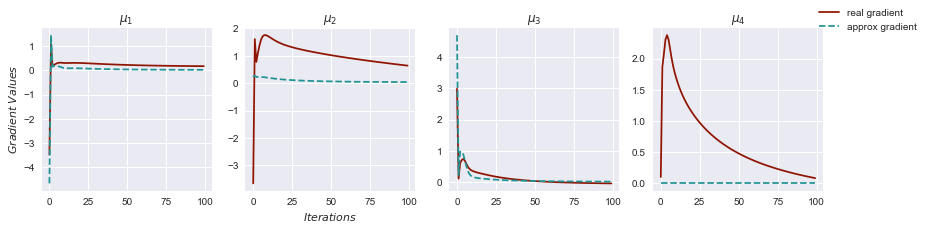

In [629]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
alltitles = ["$\mu_{1}$", "$\mu_{2}$", "$\mu_{3}$", "$\mu_{4}$"]
for i, (ax) in enumerate(np.ndarray.flatten(axs)):
    # Plot cost function evaluations
    ax.plot(np.arange(numiters), ar[:,i], label="real gradient", color="xkcd:brick red")
    ax.plot(np.arange(numiters), aa[:,i], label="approx gradient", color="#209494", linestyle="dashed")
    plt.legend
    # Axis and plot labels
    ax.set_title(f"{alltitles[i]}")

_ = axs[1].set_xlabel("$Iterations$")
_ = axs[0].set_ylabel("$Gradient$ $Values$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.savefig("images/qaoagrads.svg")
plt.show()

In [599]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])
i = np.eye(2)
mat2 = np.kron(np.kron(z, i),i)
mat3 = np.kron(np.kron(i, z),i)
mat4 = np.kron(np.kron(i, i),z)
mat5 = np.kron(np.kron(z, z),i)
mat6 = np.kron(np.kron(z, i),z)
mat7 = np.kron(np.kron(i, z),z)
mat9 = 0.5*mat2 + 0.5*mat3 + 0.5*mat4 + 0.75*(mat5 + mat6 + mat7)
eigs = np.linalg.eig(mat9)
print(np.sort(np.real(eigs[0])))

[-1.25 -1.25 -1.25 -0.25 -0.25 -0.25  0.75  3.75]
